In [2]:
import pandas as pd
import numpy as np
import scipy
import xarray as xr
import dask 

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
matplotlib.rcParams['font.family'] = 'sans-serif'

matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']

/Users/justinsimcock/miniconda3/envs/dawp/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/justinsimcock/miniconda3/envs/dawp/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [5]:
DATA_FOLDER = '~/Resilio\ Sync/FXBootcamp/*.csv'
#strategy = 'RiskPremia/'

* Changes in volatility
* Changes in volume
* Changes in bid-ask spread

In [221]:
import os
import glob

paths = glob.glob('/Users/justinsimcock/Resilio Sync/FXBootcamp/*_2019.csv')

In [222]:
df = pd.read_csv(paths[0])

In [223]:
df['Date'] = pd.to_datetime(df['Date'])
sunday_trading = df.loc[df['Date'].dt.weekday == 6 ]
sunday_trading = sunday_trading.set_index('Date')

In [224]:
sunday_trading = sunday_trading.fillna(method = 'ffill')

In [225]:
sunday_trading['spread'] = sunday_trading.ASK - sunday_trading.BID

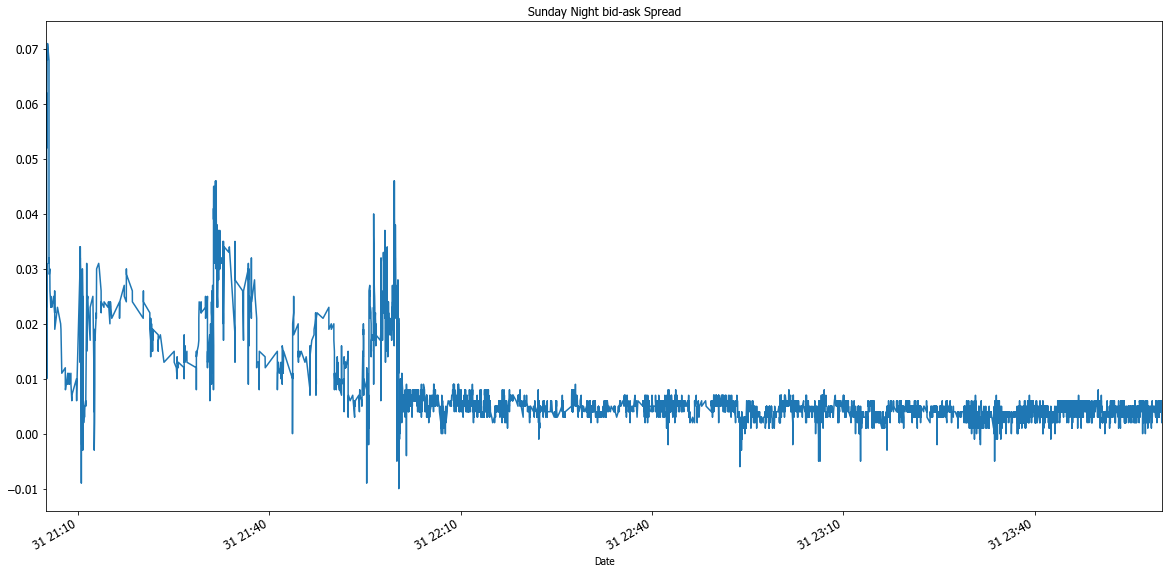

In [226]:
sunday_trading.spread.plot(figsize=(20,10), title='Sunday Night bid-ask Spread', fontsize=12);

## Sunday Open

### What was hourly tick volume like for our Sunday night trading

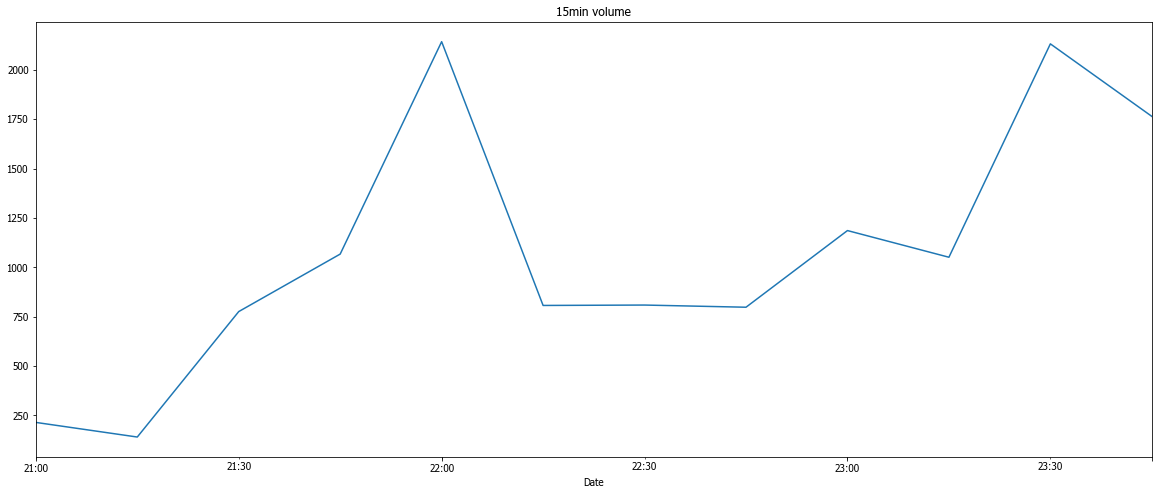

In [81]:
sunday_trading.groupby(pd.Grouper(freq='15min')).count()['BID'].plot('line', title='15min volume', figsize=(20,8))

### What was average spread size for each hour 


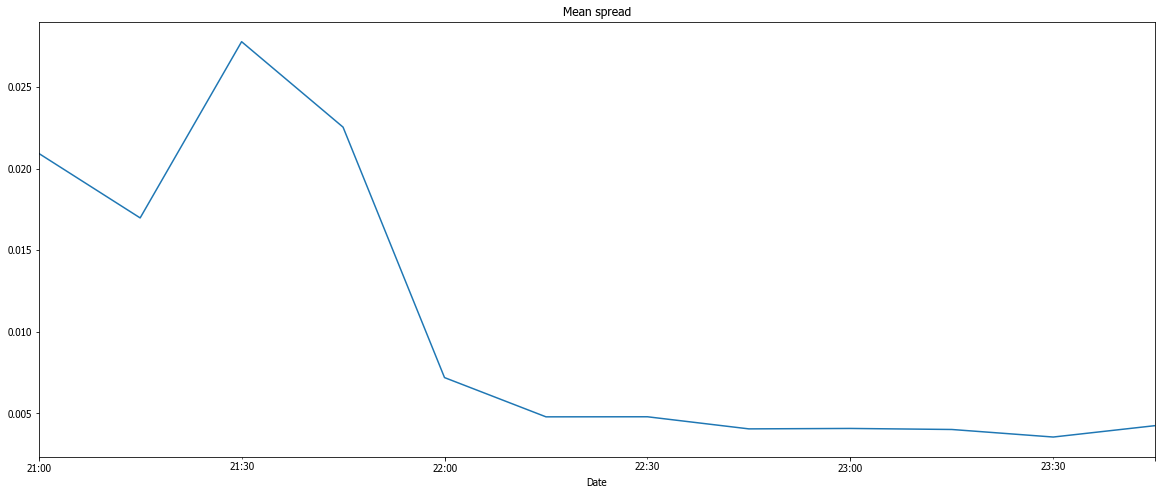

In [80]:
sunday_trading.groupby(pd.Grouper(freq='15min')).mean()['spread'].plot('line', title='Mean spread', figsize=(20,8))

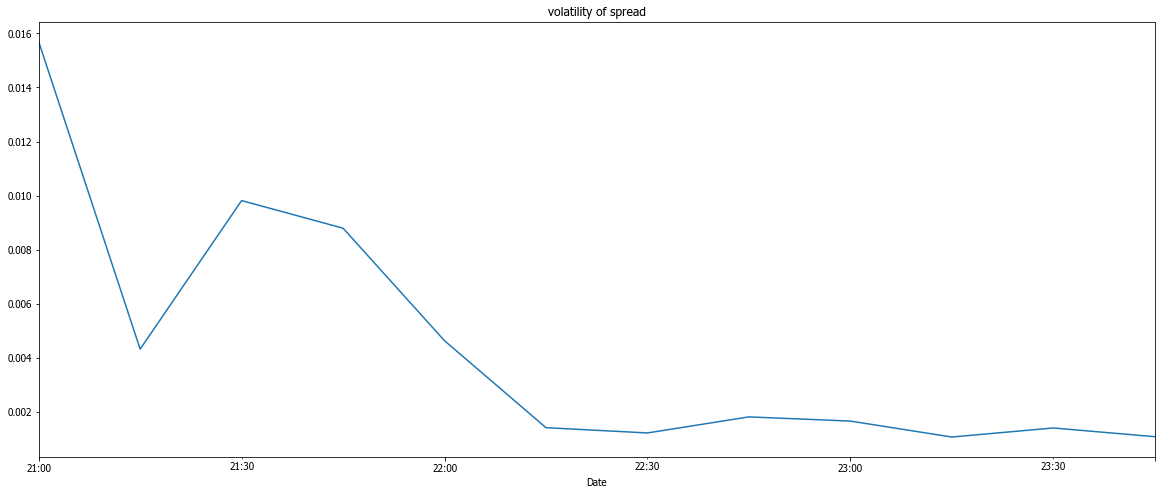

In [79]:
sunday_trading.groupby(pd.Grouper(freq='15min')).std()['spread'].plot('line', title='volatility of spread', figsize=(20,8))

### London Open (7am UTC)

In [126]:
london_open = df.loc[(df['Date'].dt.weekday == 0) & (df['Date'].dt.hour < 11) & (df['Date'].dt.hour > 4)]
london_open.head()

,Date,BID,ASK
38075,2019-04-01 05:00:04.687,111.015,NaN
38076,2019-04-01 05:00:09.000,NaN,111.018
38077,2019-04-01 05:00:09.201,NaN,111.019
38078,2019-04-01 05:00:09.533,111.016,NaN
38079,2019-04-01 05:00:09.555,NaN,111.020


In [127]:
london_open = london_open.set_index('Date')
london_open = london_open.fillna(method='ffill')
london_open['spread'] = london_open['ASK'] - london_open['BID']

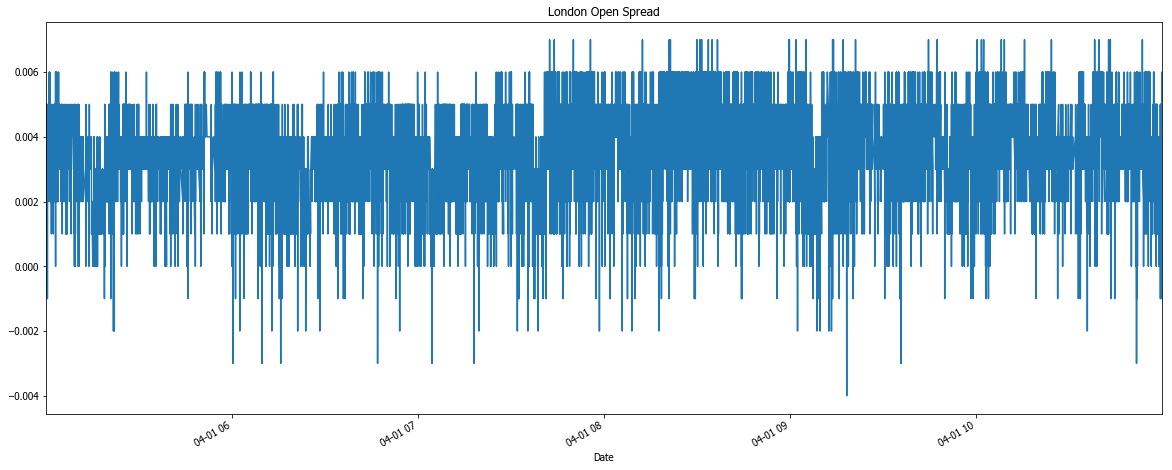

In [128]:
london_open.spread.plot(title='London Open Spread', figsize=(20,8));

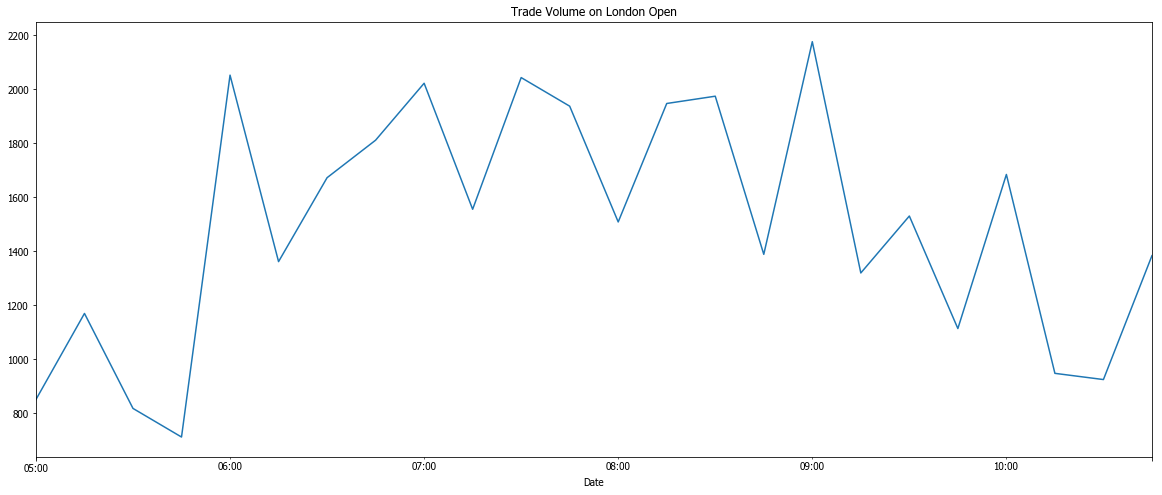

In [129]:
london_open.groupby(pd.Grouper(freq='15min')).count()['BID'].plot(title='Trade Volume on London Open', figsize=(20,8));

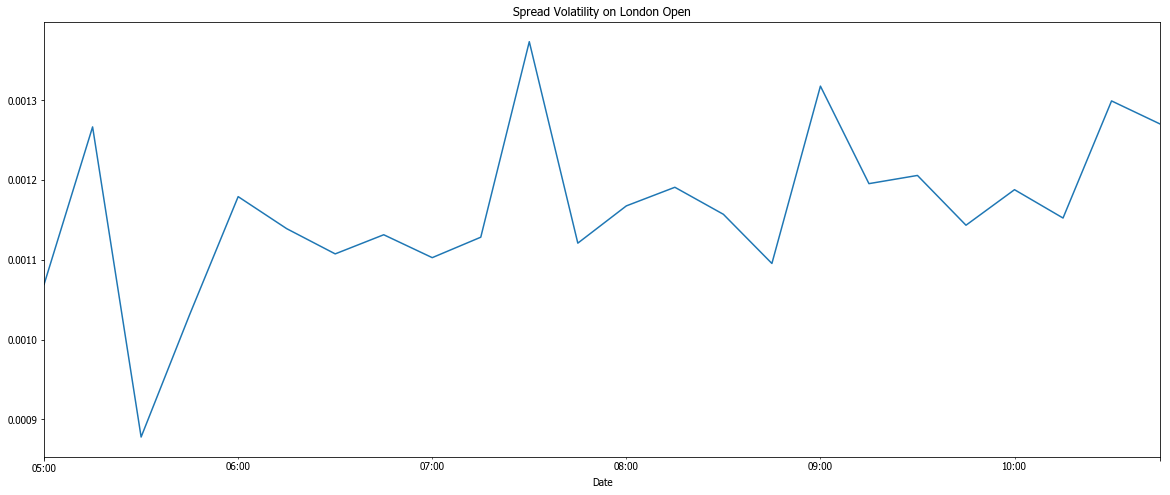

In [131]:
london_open.groupby(pd.Grouper(freq='15min')).std()['spread'].plot(title='Spread Volatility on London Open', figsize=(20,8));

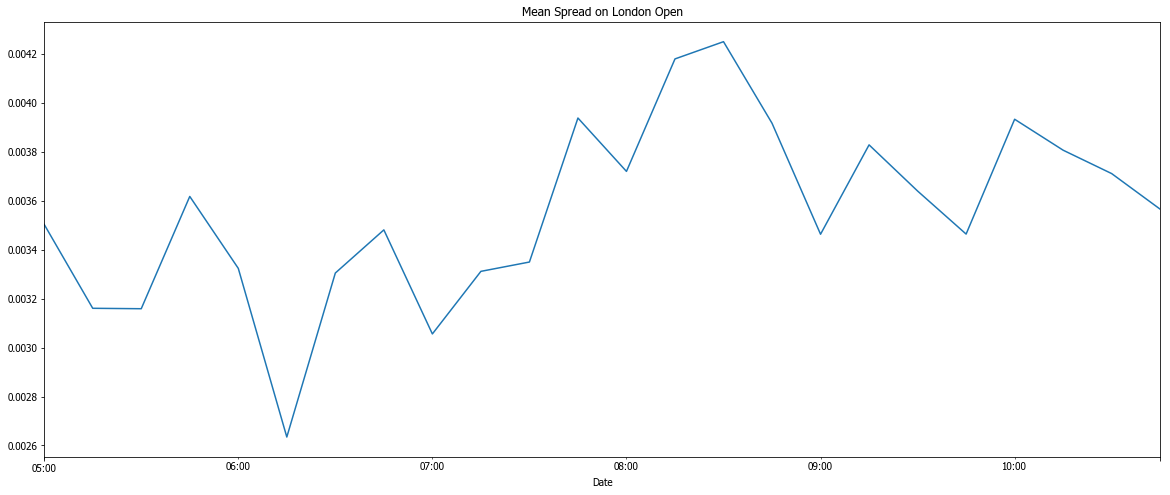

In [133]:
london_open.groupby(pd.Grouper(freq='15min')).mean()['spread'].plot(title='Mean Spread on London Open', figsize=(20,8));

### New York Open

In [238]:
nyc_open = df.loc[(df['Date'].dt.weekday == 0) & (df['Date'].dt.hour > 9) & (df['Date'].dt.hour < 15)]
nyc_open.tail()

,Date,BID,ASK
117589,2019-04-01 14:59:58.829,NaN,111.198
117590,2019-04-01 14:59:58.880,111.195,111.199
117591,2019-04-01 14:59:59.236,111.196,NaN
117592,2019-04-01 14:59:59.388,111.195,NaN
117593,2019-04-01 14:59:59.489,111.196,NaN


In [239]:
nyc_open = nyc_open.set_index('Date')
nyc_open = nyc_open.fillna(method='ffill')
nyc_open['spread'] = nyc_open['ASK'] - nyc_open['BID']

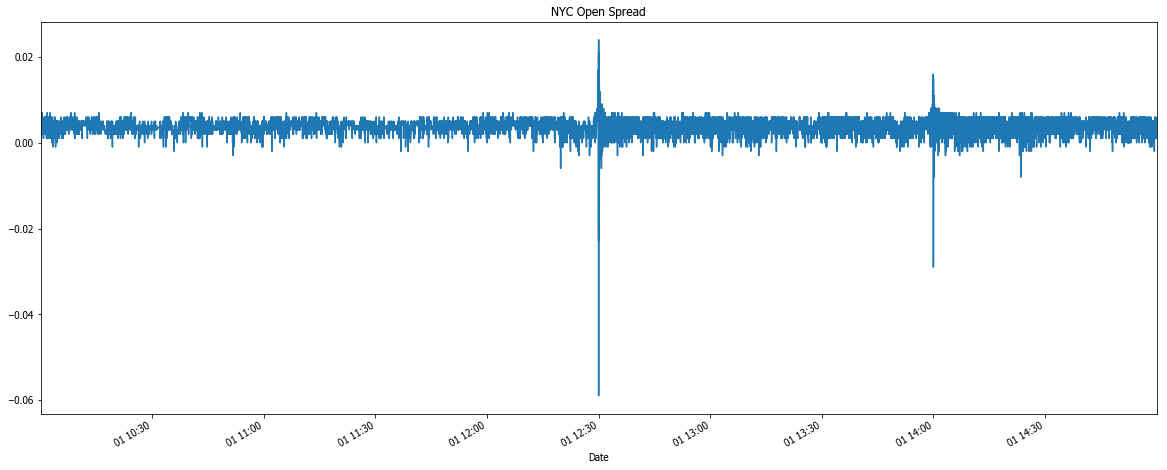

In [240]:
nyc_open.spread.plot(title='NYC Open Spread', figsize=(20,8));

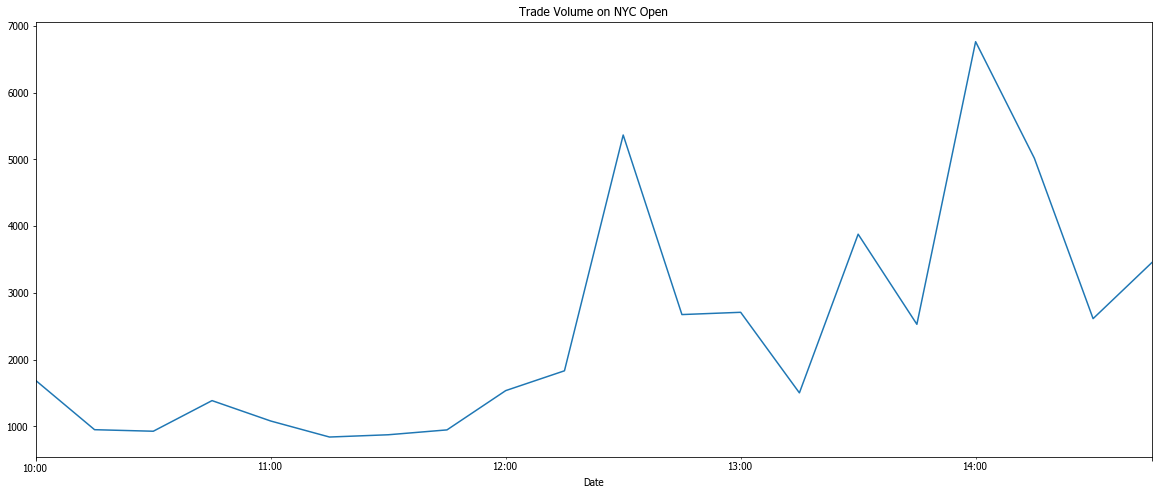

In [241]:
nyc_open.groupby(pd.Grouper(freq='15min')).count()['BID'].plot(title='Trade Volume on NYC Open', figsize=(20,8));

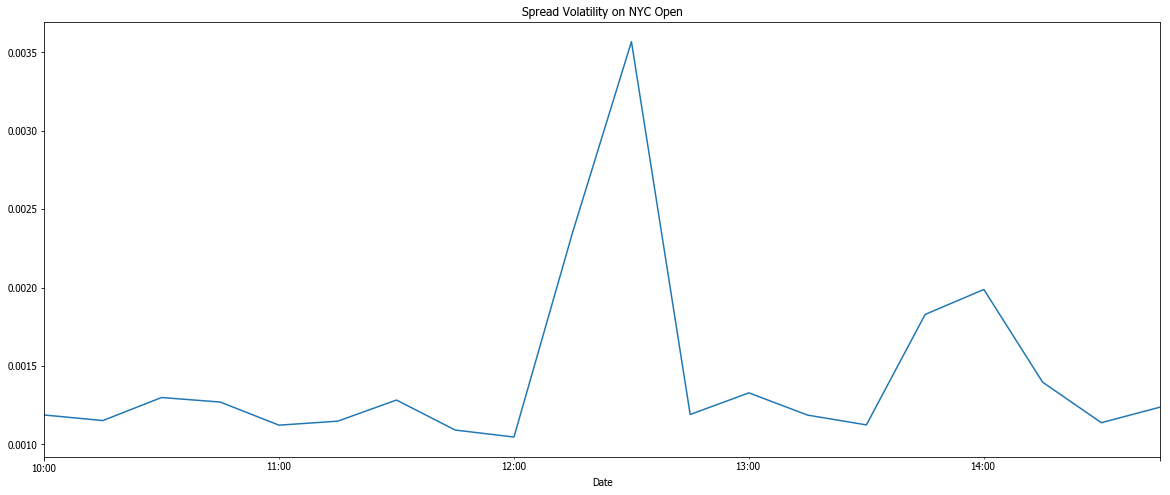

In [242]:
nyc_open.groupby(pd.Grouper(freq='15min')).std()['spread'].plot(title='Spread Volatility on NYC Open', figsize=(20,8));

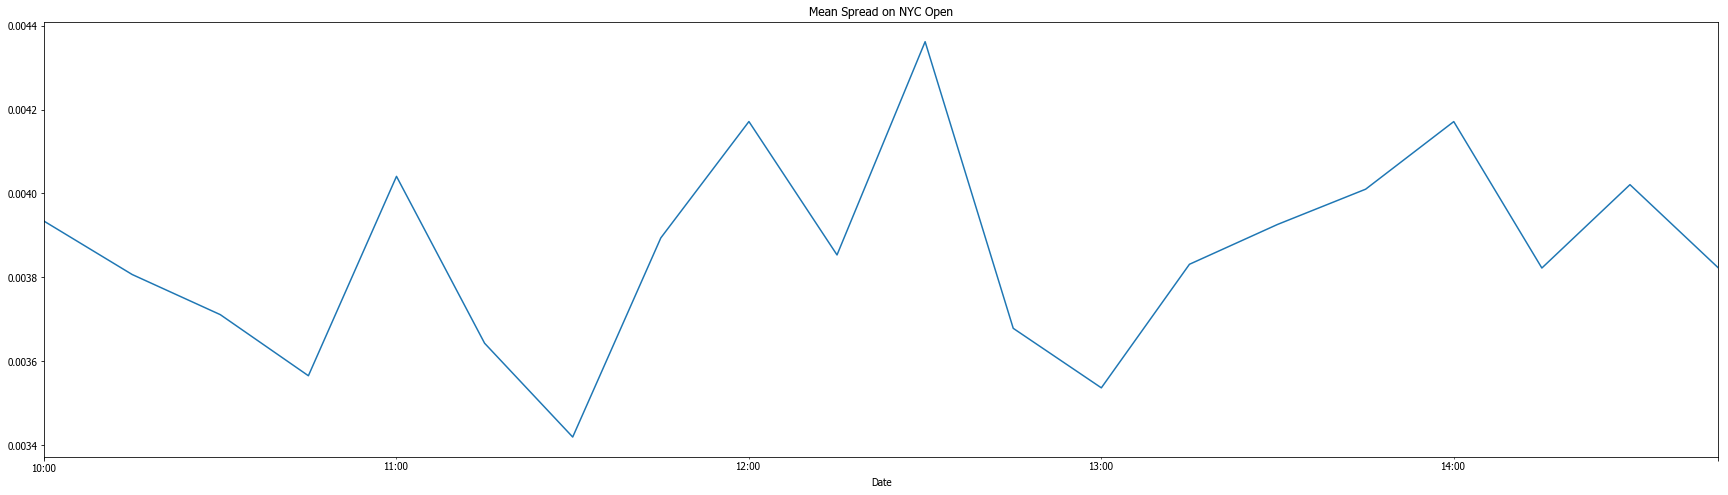

In [295]:
nyc_open.groupby(pd.Grouper(freq='15min')).mean()['spread'].plot(title='Mean Spread on NYC Open', figsize=(30,8));

### Do we see any mean reversion behavior during NYC open?

* For this period, I don't see any evidence of momentum or reversal

In [283]:
nyc_open['price'] = (nyc_open.ASK + nyc_open.BID)/2
ohlc_15_nyc_open = nyc_open.price.resample('5min').ohlc()
high_volm_periods = nyc_open.groupby(pd.Grouper(freq='5min')).count()['BID'].sort_values(ascending=False)[:5]

In [ ]:
ohlc_15_nyc_open

In [268]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [290]:
from math import pi 

inc = ohlc_15_nyc_open.close > ohlc_15_nyc_open.open
dec = ohlc_15_nyc_open.open > ohlc_15_nyc_open.close
w = 15*60*100 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Open Candlesticks")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(ohlc_15_nyc_open.index, ohlc_15_nyc_open.high, ohlc_15_nyc_open.index, ohlc_15_nyc_open.low, color="black")
p.vbar(ohlc_15_nyc_open.index[inc], w, ohlc_15_nyc_open.open[inc], ohlc_15_nyc_open.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(ohlc_15_nyc_open.index[dec], w, ohlc_15_nyc_open.open[dec], ohlc_15_nyc_open.close[dec], fill_color="#F2583E", line_color="black")

# p.line(high_volm_periods, np.linspace(0,112))

# output_file("candlestick.html", title="candlestick.py example")
output_notebook()
show(p)  # open a browser

Loading BokehJS ...

In [296]:
# US Economic Data Release (between 8:30 AM and 10:00AM NY)

In [297]:
# Option Expiry (10AM NY)

In [298]:
# The WM/Reuters Benchmark Fix (4PM London)

In [299]:
# The CME Close (3PM NY)

In [300]:
# The China Fix (9:15AM Shanghai)

In [301]:
# The Tokyo Fix (8:55AM Tokyo)

In [302]:
#Crude Oil Inventory Estimates
#DoE – Weds 10:30AM NY
#API – Tuesday 4:30PM NY

In [303]:
#The NYMEX Open and Close (9AM NY, 2PM NY)

In [305]:
#The Friday Close 5PM NY time on Friday.